In [96]:
# Initialize Otter
import otter
grader = otter.Notebook("lab02.ipynb")

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode

# Lab 2: API and Data Cleaning

This lab consists of two sections: the first section will give you a practice in making a simple API call to fetch economic data using the general method; the rest of the lab takes a look at IPUMS census data and improves your ability to clean and manipulate data. 

#### Learning Objectives
- How to make an API call to extract data in the basic settings. 
- How to postprocess the API response and convert the returned data into a dataframe. 
- Filter a dataset for relevant rows and columns. 
- Use groupby and common aggregation techniques. 
- Sort the dataframe by a column. 

----
## Section 1: Phillips Curve and FRED API
In lab 1, we plotted an empirical Phillips curve using data that we had locally. This time, we will go one step further and use an API (Application Programming Interface) to get the data from FRED. In this section, we will introduce the general method of interacting with online data sources through an API, using [FRED API](https://fred.stlouisfed.org/docs/api/fred/) as a simple example. 

### Step 1: Get the API Key
**In most cases, you will need to obtain an API key in order to access an API.** For many resources, this involves some paperwork to apply and/or have limited free usage, so it is good practice to keep your API keys private as long as it is possible. In this lecture notebook, we will use macroeconomic data from FRED, which is one of the most popular and convenient sources of economic data. For FRED, the process of obtaining an API key is simple. Request the API key [here](https://fred.stlouisfed.org/docs/api/api_key.html). 

**Question 1.1:** Request an API key at FRED and paste your API key below. 

Note: For submission, feel free to redact your API key (i.e. replace it with some arbitrary strings); our autograder is configured to not use your API key in testing. It is a good practice not to include your API keys in files that you will share with others. 

In [98]:
api_key = "0fbd84472d204b6361f2ba22dbe73e7a"

In [99]:
grader.check("q1_1")

q1_1 results: All test cases passed!

### Step 2: Learn to use the API
Using an API is like ordering food at a restaurant with a menu. In order to have a delicious meal, we need to know what foods the restaurant offers, and any other additional information (for example, how would you like your steak). Similarly, it is very important for us to know what requests an API will make by reading the API documentation. **The API documentation will tell us about how to use specific commands to get the data that we want, and what the data returned will look like.** Check out the Fred API's documentation [here](https://fred.stlouisfed.org/docs/api/fred/series_observations.html). 

<!-- BEGIN QUESTION -->

**Question 1.2:** Identify the parameters and their values you must use if you want to obtain year-over-year real GDP percentage changes (i.e. percent change from year ago values). 

Hint: You can look up the `series_id` of real GDP by searching it on Fred's website. It should be listed in parentheses next to the name of the series. 

"real_time_start", "real_time_end", "data", and "value"

<!-- END QUESTION -->

### Step 3: Make the fetch!
Now we are ready to start writing code to fetch the data we want through the API. 

**Question 1.3:** Complete the function below that can fetch json data given `base_url`, `endpoint` and `params` using the [`requests`](https://pypi.org/project/requests/) module.  

Hint 1: See Question 1.4 to find out how `base_url`, `endpoint` and `params`look like.

Hint 2: Python has special strings called **f-strings** where it fills in the value of a variable for you. For example:

```python
>>> arr = np.array([1, 2, 3])
>>> print(f"The second element of arr is {arr[1]}")
The second element of arr is 2
```
You may want to use f-strings when you put together the query url from `base_url`, `endpoint` and `url_params`. 

In [100]:
def fetch(base_url, endpoint, params, url_only=False):
    # forms API request
    url_params = urlencode(params)
    url = f"{base_url}{endpoint}?{url_params}"
    
    # For testing purposes only, do not delete
    if url_only:
        return url
    
    # fires off the request
    res = requests.get(url)
    
    # checks if the request encounters an error
    if res.status_code not in range(200, 299):
        raise Exception(f"Fetch request failed (Error: {res.status_code})")
    
    # return the content of the response
    return res.json()

In [101]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4:** We want to get **quarterly** unemployment data (series id: **UNRATE**) **from the first quarter in 1958 (1958-01-01) to the last quarter in 2022 (2022-10-01)** from Fred API. Complete the code below to fetch and construct a dataframe with two columns, `date` and `unrate`. 

Note: Use observation period for dates. You don't need to sort the data--use the default ordering. If you need to aggregate the data, use the default averaging method.   

In [102]:
base_url = "https://api.stlouisfed.org"
endpoint = "/fred/series/observations"
params_UNRATE = {"series_id": "UNRATE", 
                 "observation_start": "1958-01-01",
                 "observation_end": "2022-10-01",
                 "units": "lin",
                 "frequency": "q",
                 "api_key": api_key,
                 "file_type": "json"
                }

# fetch data
res_json_UNRATE = fetch(base_url, endpoint, params_UNRATE)


# process json data and store it as a dataframe
unemployment = pd.DataFrame(res_json_UNRATE["observations"])[["date", "value"]] # hint: look at what's inside of `res_json_UNRATE`
unemployment.rename(columns={"value": "unrate"}, inplace=True)
unemployment

,date,unrate
0,1958-01-01,6.3
1,1958-04-01,7.4
2,1958-07-01,7.3
3,1958-10-01,6.4
4,1959-01-01,5.8
...,...,...
255,2021-10-01,4.2
256,2022-01-01,3.8
257,2022-04-01,3.6
258,2022-07-01,3.6


In [103]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5:** Now we want to get the inflation data. This time we will be using **percent change from year ago** core CPI data (series id: **CPILFESL**) as our inflation measure. Get the **quarterly data from the first quarter in 1958 (1958-01-01) to the last quarter in 2022 (2022-10-01)** from Fred API. Complete the code below to fetch and construct a dataframe with two columns, `date` and `inflation`. 

Note: Use observation period for dates. You don't need to sort the data--use the default ordering. If you need to aggregate the data, use the default averaging method. 

In [104]:
params_INFLATION = {"series_id": "CPILFESL", 
                 "observation_start": "1958-01-01",
                 "observation_end": "2022-10-01",
                 "units": "pc1",
                 "frequency": "q",
                 "api_key": api_key,
                 "file_type": "json"
                }

# fetch data
res_json_INFLATION = fetch(base_url, endpoint, params_INFLATION)

# process json data and store it as a dataframe
inflation = pd.DataFrame(res_json_INFLATION["observations"])[["date", "value"]] # hint: look at what's inside of `res_json_INFLATION`
inflation.rename(columns={"value": "inflation"}, inplace=True)
inflation

,date,inflation
0,1958-01-01,2.79720
1,1958-04-01,2.42775
2,1958-07-01,2.06659
3,1958-10-01,1.82232
4,1959-01-01,1.81406
...,...,...
255,2021-10-01,5.00808
256,2022-01-01,6.29779
257,2022-04-01,6.01857
258,2022-07-01,6.29602


In [105]:
grader.check("q1_5")

q1_5 results: All test cases passed!

### Step 4: Plot empirical Phillips curve (again)
And now we can graph our empirical Phillips curve!

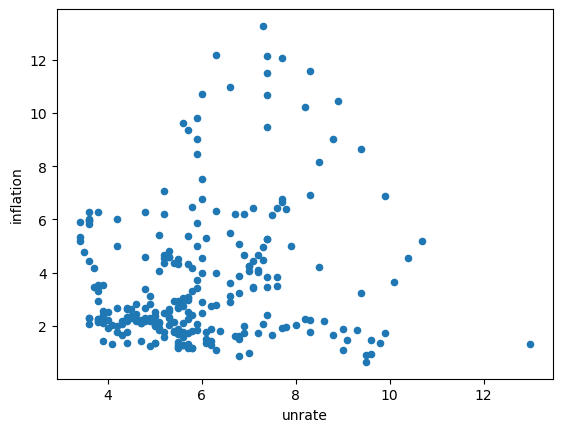

In [106]:
phillips_curve_df = unemployment.merge(inflation, how="inner", on="date")

# convert data types from strings to floats
phillips_curve_df['unrate'] = phillips_curve_df['unrate'].astype(float)
phillips_curve_df['inflation'] = phillips_curve_df['inflation'].astype(float)

phillips_curve_df.plot.scatter('unrate', 'inflation');

Check to see if this looks the same as in Lab 1!

----
## Section 2: College Majors
This section is inspired by ["The Economic Guide To Picking A College Major"](https://fivethirtyeight.com/features/the-economic-guide-to-picking-a-college-major/) by FiveThirtyEight. We won't be doing the full length of analysis here.

### Import Data
The dataset is a data extract from [IPUMS USA](https://usa.ipums.org/usa/) for the 2019 ACS and the 2009 ACS.  IPUMS USA collects, preserves and harmonizes U.S. census microdata and provides easy access to these data with enhanced documentation. Data include decennial censuses from 1790 to 2010 and American Community Surveys (ACS) from 2000 to the present. 

In this part of the lab, we will use a fraction (about 6\%) of the data due to Datahub's memory limitation. Feel free to download the entire IPUMS data and play around with it on your local machine. 

First, we will import the data sample. 

In [107]:
ipums_raw = pd.read_csv("data/ipums-acs-sample.csv")
ipums_raw

,YEAR,SAMPLE,SERIAL,CBSERIAL,AGE,SCHOOL,EDUC,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,200901,19,1138,58,1,10,101,62,6203,0,0,1,10,420,40000,40000,40656.0
1,2009,200901,47,3200,56,1,7,71,0,0,0,0,3,30,0,11000,0,0.0
2,2009,200901,81,5508,7,2,1,12,0,0,0,0,0,0,0,9999999,999999,NaN
3,2009,200901,89,5890,13,2,2,23,0,0,0,0,0,0,0,9999999,999999,NaN
4,2009,200901,95,6104,93,1,6,61,0,0,0,0,3,30,0,8100,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2019,201901,1427987,2019001384908,76,1,11,114,23,2306,0,0,3,30,0,126800,0,0.0
199996,2019,201901,1427991,2019001385560,17,2,5,50,0,0,0,0,3,30,0,0,0,0.0
199997,2019,201901,1428005,2019001395346,32,1,6,63,0,0,0,0,1,10,7810,24000,24000,20470.0
199998,2019,201901,1428005,2019001395346,6,2,1,12,0,0,0,0,0,0,0,9999999,999999,NaN


**Question 2.1:** We have noticed that there are some missing values in the data. To deal with these missing values, complete the code below to drop these missing values from the dataframe. In the future, we will learn about other ways to handle missing values. 

In [108]:
# drop rows with missing values
ipums_raw = ipums_raw.dropna()
ipums_raw = ipums_raw.reset_index()
ipums_raw.shape[0]

162731

In [109]:
grader.check("q2_1")

q2_1 results: All test cases passed!

### Select Revelant Variables

The original dataset contains many variables used to identify a particular household, a person, and their corresponding weights in the sample. These are not our concern, so we will not keep these columns around. 

Below are the variables we want in the dataframe. 

| Variable | Label | Description |
| --- | --- | --- |
| YEAR | Census year | YEAR reports the four-digit year when the household was enumerated or included in the census, the ACS, and the PRCS. |
| AGE | Age | AGE reports the person's age in years as of the last birthday. |
| SCHOOL | School attendance | SCHOOL indicates whether the respondent attended school during a specified period. |
| EDUCD | Educational attainment (detailed version) | EDUC indicates respondents' educational attainment, as measured by the highest year of school or degree completed. |
| DEGFIELD | Field of degree (general version) | DEGFIELD reports the field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree. |
| DEGFIELDD | Field of degree (detailed version) | DEGFIELD reports the field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree. |
| DEGFIELD2 | Field of degree (2) (general version) | DEGFIELD2 reports the second field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree in a second field. |
| DEGFIELD2D | Field of degree (2) (detailed version) | DEGFIELD2 reports the second field in which the person received a Bachelor's degree, if the person holds a Bachelor's degree in a second field. |
| EMPSTAT | Employment status (general version) | EMPSTAT indicates whether the respondent was a part of the labor force -- working or seeking work -- and, if so, whether the person was currently unemployed. |
| OCC | Occupation | OCC reports the person's primary occupation, coded into a contemporary census classification scheme |
| INCTOT | Total personal income | INCTOT reports each respondent's total pre-tax personal income or losses from all sources for the previous year. |
| INCWAGE | Wage and salary income | INCWAGE reports each respondent's total pre-tax wage and salary income - that is, money received as an employee - for the previous year.  |
| INCWAGE_CPIU_2010 | Wage and salary income (standardized using CPIU_2010) | INCWAGE reports each respondent's total pre-tax wage and salary income - that is, money received as an employee - for the previous year. |

In [110]:
ipums = ipums_raw[["YEAR", "AGE", "SCHOOL", "EDUCD", "DEGFIELD", 
                   "DEGFIELDD", "DEGFIELD2", "DEGFIELD2D", "EMPSTAT", 
                   "OCC", "INCTOT", "INCWAGE", "INCWAGE_CPIU_2010"
                  ]].copy()
ipums

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
1,2009,56,1,71,0,0,0,0,3,0,11000,0,0.0
2,2009,93,1,61,0,0,0,0,3,0,8100,0,0.0
3,2009,35,1,71,0,0,0,0,3,8140,51000,51000,51837.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162726,2019,58,1,63,0,0,0,0,1,4720,400,400,341.0
162727,2019,76,1,114,23,2306,0,0,3,0,126800,0,0.0
162728,2019,17,2,50,0,0,0,0,3,0,0,0,0.0
162729,2019,32,1,63,0,0,0,0,1,7810,24000,24000,20470.0


### Individuals with College Degrees
Since we are interested in how different college degrees affect income, we need to filter the dataset for those individuals who have a college degree (at least a bachelor's degree). 

| EDUCD | Description |
| --- | --- |
| ... | ... (rows omitted) |
| 090 | 3 years of college |
| 100 | 4 years of college |
| 101 | Bachelor's degree |
| 110 | 5+ years of college |
| 111 | 6 years of college (6+ in 1960-1970) |
| 112 | 7 years of college |
| 113 | 8+ years of college |
| 114 | Master's degree |
| 115 | Professional degree beyond a bachelor's degree |
| 116 | Doctoral degree |
| 999 | Missing |

Note that records with `EDUCD` greater than or equal to 101 but less than 999 represent a valid record for a person with a college degree. We will use this criterion to filter the dataset. 

**Question 2.2:** Filter the `ipums` dataframe for individuals with a college degree based on the criteria given above. 

In [111]:
ipums_college = ipums[ipums["EDUCD"].between(101, 999)]
ipums_college

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
8,2009,72,2,101,23,2300,0,0,3,0,5400,0,0.0
13,2009,38,1,101,62,6201,0,0,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,0,0,3,0,9700,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162719,2019,81,1,101,23,2305,0,0,3,0,45000,0,0.0
162720,2019,36,1,101,62,6200,0,0,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,0,0,1,2310,42000,42000,35823.0
162727,2019,76,1,114,23,2306,0,0,3,0,126800,0,0.0


In [112]:
grader.check("q2_2")

q2_2 results: All test cases passed!

### Individuals in Workforce

Juniors who cannot work and seniors who have retired from work will not have wages and salaries. We want to exclude them from our analysis. Assume that working age means 15-64 years old (inclusive). 

**Question 2.3:** Filter the dataframe `ipums_college` for individuals within the working age. 

In [113]:
ipums_college_working_age = ipums_college[ipums_college["AGE"].between(15, 64)]
ipums_college_working_age

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
13,2009,38,1,101,62,6201,0,0,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,0,0,3,0,9700,0,0.0
18,2009,47,1,101,53,5301,0,0,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,11,1103,0,0,3,205,92000,0,0.0
162717,2019,63,1,115,61,6105,0,0,1,3090,12000,12000,10235.0
162720,2019,36,1,101,62,6200,0,0,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,0,0,1,2310,42000,42000,35823.0


In [114]:
grader.check("q2_3")

q2_3 results: All test cases passed!

### Double Majors

Some individuals have double majors. The way the IPUMS ACS dataset captures this is by reporting values in `DEGFIELD2` in addition to `DEGFIELD`. This can complicate our analysis because these individuals' earnings are likely to be affected by both of their majors, while the proportion of influence from each major is unknown. 

To remove this bias from our analysis, we will stick to individuals with only one college major. We will do that for you here. 

In [115]:
ipums_single_major = ipums_college_working_age[ipums_college_working_age["DEGFIELD2"] == 0]
ipums_single_major

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,62,6203,0,0,1,420,40000,40000,40656.0
4,2009,29,1,101,62,6206,0,0,1,4850,50000,50000,50820.0
13,2009,38,1,101,62,6201,0,0,1,800,37000,37000,37607.0
14,2009,64,1,101,23,2300,0,0,3,0,9700,0,0.0
18,2009,47,1,101,53,5301,0,0,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,11,1103,0,0,3,205,92000,0,0.0
162717,2019,63,1,115,61,6105,0,0,1,3090,12000,12000,10235.0
162720,2019,36,1,101,62,6200,0,0,1,910,107700,106000,90410.0
162724,2019,39,1,101,23,2304,0,0,1,2310,42000,42000,35823.0


In [116]:
ipums_s = ipums_single_major.drop(['DEGFIELD2', 'DEGFIELD2D'], axis=1)

### What Are Those Majors?

Majors in the dataframe (`DEGFIELD`, `DEGFIELDD`) are coded as integers. To find out what each code corresponds to, we will use a conversion dictionary given below. 

In [117]:
degfield = pd.read_csv("data/degfield.txt", sep='\t').set_index("value").to_dict()["label"]
degfieldd = pd.read_csv("data/degfieldd.txt", sep='\t').set_index("value").to_dict()["label"]
print(degfield)

{0: nan, 11: 'Agriculture', 13: 'Environment and Natural Resources', 14: 'Architecture', 15: 'Area, Ethnic, and Civilization Studies', 19: 'Communications', 20: 'Communication Technologies', 21: 'Computer and Information Sciences', 22: 'Cosmetology Services and Culinary Arts', 23: 'Education Administration and Teaching', 24: 'Engineering', 25: 'Engineering Technologies', 26: 'Linguistics and Foreign Languages', 29: 'Family and Consumer Sciences', 32: 'Law', 33: 'English Language, Literature, and Composition', 34: 'Liberal Arts and Humanities', 35: 'Library Science', 36: 'Biology and Life Sciences', 37: 'Mathematics and Statistics', 38: 'Military Technologies', 40: 'Interdisciplinary and Multi-Disciplinary Studies (General)', 41: 'Physical Fitness, Parks, Recreation, and Leisure', 48: 'Philosophy and Religious Studies', 49: 'Theology and Religious Vocations', 50: 'Physical Sciences', 51: 'Nuclear, Industrial Radiology, and Biological Technologies', 52: 'Psychology', 53: 'Criminal Justic

`DEGFIELD` gives a more general major field. For example, `DEGFIELD` of 55 corresponds to social sciences. 

`DEGFIELDD` gives a more detailed major field. For example, `DEGFIELDD` of 5501 corresponds to Economics. 

Now we will replace all the code in `DEGFIELD` (majors) with texts. 

**Question 2.4:** Complete the following function `replace_code_w_text`, which replaces degree of field codes in column `col` in the dataframe `data` with corresponding texts according to the `ref` dictionary. Hint: you may want to use [`pd.DataFrame.apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html). 

In [118]:
# returns the corresponding text given `code`
# (you can also use a lambda function instead
# of this function)
def get_text(code, ref):
    return ref[code]

def replace_code_w_text(data, col, ref):
    output = data.copy()
    output[col] = output[col].apply(lambda x: get_text(x, ref))
    return output

ipums_s_text = ipums_s.copy()
ipums_s_text = replace_code_w_text(ipums_s_text, "DEGFIELD", degfield)
ipums_s_text = replace_code_w_text(ipums_s_text, "DEGFIELDD", degfieldd)
ipums_s_text

,YEAR,AGE,SCHOOL,EDUCD,DEGFIELD,DEGFIELDD,EMPSTAT,OCC,INCTOT,INCWAGE,INCWAGE_CPIU_2010
0,2009,58,1,101,Business,Business Management and Administration,1,420,40000,40000,40656.0
4,2009,29,1,101,Business,Marketing and Marketing Research,1,4850,50000,50000,50820.0
13,2009,38,1,101,Business,Accounting,1,800,37000,37000,37607.0
14,2009,64,1,101,Education Administration and Teaching,General Education,3,0,9700,0,0.0
18,2009,47,1,101,Criminal Justice and Fire Protection,Criminal Justice and Fire Protection,1,2010,68500,58000,58951.0
...,...,...,...,...,...,...,...,...,...,...,...
162715,2019,46,1,101,Agriculture,Animal Sciences,3,205,92000,0,0.0
162717,2019,63,1,115,Medical and Health Sciences and Services,Medical Technologies Technicians,1,3090,12000,12000,10235.0
162720,2019,36,1,101,Business,General Business,1,910,107700,106000,90410.0
162724,2019,39,1,101,Education Administration and Teaching,Elementary Education,1,2310,42000,42000,35823.0


In [119]:
grader.check("q2_4")

q2_4 results: All test cases passed!

----
## Section 3: The Most Lucrative Major
Now, we will try to find out which major graduates get the best salary. We will also take a look at how things have changed from 2009 to 2019. 

### In 2009

Let's take a look at the most lucrative majors as of 2009. 

**Question 3.1:** Filter the `ipums_s` dataframe for records for 2009. Then find the median total income (`INCTOT`) and the median wage and salary (`INCWAGE`) for each major (`DEGFIELDD`). The resulting dataframe should have only three columns: `DEGFIELDD`, `INCTOT`, `INCWAGE` (in that order). 

Hint: You may want to use [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) with a correct aggregation function. 

In [87]:
ipums_s_2009 = ipums_s_text.query("YEAR == 2009")
ipums_s_2009_by_major = ipums_s_2009.groupby("DEGFIELDD").agg({"INCTOT" : "median", "INCWAGE": "median"})
ipums_s_2009_by_major = ipums_s_2009_by_major.reset_index()
ipums_s_2009_by_major

,DEGFIELDD,INCTOT,INCWAGE
0,Accounting,60375.0,52500.0
1,Actuarial Science,350700.0,356000.0
2,Advertising and Public Relations,37050.0,31000.0
3,Aerospace Engineering,73500.0,71000.0
4,Agricultural Economics,48100.0,39000.0
...,...,...,...
166,Transportation Sciences and Technologies,69510.0,60000.0
167,Treatment Therapy Professions,50000.0,40000.0
168,United States History,48050.0,31000.0
169,Visual and Performing Arts,32500.0,22500.0


In [88]:
grader.check("q3_1")

q3_1 results: All test cases passed!

#### Ranking by Wage and Salaries

**Question 3.2:** Sort the `ipums_s_2009_by_major` by wage and salary (`INCWAGE`) in descending order.

In [89]:
ipums_s_2009_highest_incwage_majors = ipums_s_2009_by_major.sort_values(by="INCWAGE", ascending=False)
ipums_s_2009_highest_incwage_majors

,DEGFIELDD,INCTOT,INCWAGE
1,Actuarial Science,350700.0,356000.0
79,Geosciences,130000.0,130000.0
130,Nuclear Engineering,120015.0,120000.0
137,Petroleum Engineering,110000.0,110000.0
123,Miscellaneous Social Sciences,120000.0,110000.0
...,...,...,...
86,Humanities,10550.0,10550.0
156,Social Psychology,31200.0,10000.0
129,Neuroscience,12800.0,9800.0
149,Precision Production and Industrial Arts,39000.0,4900.0


In [90]:
grader.check("q3_2")

q3_2 results: All test cases passed!

### In 2019

To find out how things have changed from 2009 to 2019, we will do the same for 2019. 

**Question 3.3:** Create a dataframe `ipums_s_2019_highest_incwage_majors` that contains the sorted median wage for each major. The dataframe is sorted in descreasing order on the variable of interest. 

Hint: Start by copying the code you used for 2009.

In [91]:
ipums_s_2019 = ipums_s_text.query("YEAR == 2019")
ipums_s_2019_by_major = ipums_s_2019.groupby("DEGFIELDD").agg({"INCTOT" : "median", "INCWAGE": "median"})
ipums_s_2019_by_major = ipums_s_2019_by_major.reset_index()
ipums_s_2019_highest_incwage_majors = ipums_s_2019_by_major.sort_values(by="INCWAGE", ascending=False)

In [92]:
grader.check("q3_3")

q3_3 results: All test cases passed!

### Comparison
There seems to be a significant change in the most lucrative majors from 2009 to 2019. Let's compare them now.

The first thing to do is to select the top ten highest paid majors from 2009 and 2019. 

In [93]:
top_ten_majors = list(set(list(ipums_s_2009_highest_incwage_majors.iloc[:10]["DEGFIELDD"]) + 
                          list(ipums_s_2019_highest_incwage_majors.iloc[:10]["DEGFIELDD"])
                         ))
top_ten_majors

['Aerospace Engineering',
 'Actuarial Science',
 'Cognitive Science and Biopsychology',
 'Materials Engineering and Materials Science',
 'Nuclear Engineering',
 'Geosciences',
 'Petroleum Engineering',
 'Pharmacy, Pharmaceutical Sciences, and Administration',
 'Atmospheric Sciences and Meteorology',
 'Electrical Engineering',
 'Military Technologies',
 'Pharmacology',
 'Mining and Mineral Engineering',
 'Chemical Engineering',
 'Materials Science',
 'Applied Mathematics',
 'Physical Sciences',
 'Mathematics and Computer Science',
 'Naval Architecture and Marine Engineering',
 'Miscellaneous Social Sciences']

In [94]:
ipums_s_2019_highest_incwage_majors

,DEGFIELDD,INCTOT,INCWAGE
129,Naval Architecture and Marine Engineering,181750.0,132500.0
107,Mathematics and Computer Science,130000.0,130000.0
138,Pharmacology,126100.0,125000.0
114,Mining and Mineral Engineering,120000.0,120000.0
104,Materials Science,110000.0,110000.0
...,...,...,...
42,Counseling Psychology,36850.0,20000.0
26,Clinical Psychology,37500.0,20000.0
14,Astronomy and Astrophysics,11000.0,11000.0
54,Electrical and Mechanic Repairs and Technologies,27500.0,5000.0


Next, we'll filter the table for only these majors. We'll see how they changed from 2009 to 2019.

**Question 3.4:** Filter the `ipums_s_2019_highest_incwage_majors` and `ipums_s_2009_highest_incwage_majors` for only those majors (`DEGFIELDD`) in the `top_ten_majors` list, and then merge them together. Finally, sort the dataframe by wages and salaries in 2009 in a descending order. 

Hint: You may want to use [`isin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html).

In [141]:
ipums_2019_top_ten_majors = ipums_s_2019_highest_incwage_majors[ipums_s_2019_highest_incwage_majors["DEGFIELDD"].isin(top_ten_majors)]
ipums_2019_top_ten_majors = ipums_2019_top_ten_majors.rename(
    columns={"INCTOT": "INCTOT_2019", "INCWAGE": "INCWAGE_2019"}
) # rename the columns

ipums_2009_top_ten_majors = ipums_s_2009_highest_incwage_majors[ipums_s_2009_highest_incwage_majors["DEGFIELDD"].isin(top_ten_majors)]
ipums_2009_top_ten_majors = ipums_2009_top_ten_majors.rename(
    columns={"INCTOT": "INCTOT_2009", "INCWAGE": "INCWAGE_2009"}
) # rename the columns

# # merge and sort here
ipums_top_ten_majors = ipums_2019_top_ten_majors.merge(ipums_2009_top_ten_majors, on="DEGFIELDD")
ipums_top_ten_majors = ipums_top_ten_majors.sort_values(["INCWAGE_2009"], ascending=[0])
ipums_top_ten_majors

,DEGFIELDD,INCTOT_2019,INCWAGE_2019,INCTOT_2009,INCWAGE_2009
17,Actuarial Science,3150.0,3150.0,350700.0,356000.0
9,Geosciences,95000.0,95000.0,130000.0,130000.0
14,Nuclear Engineering,81000.0,75000.0,120015.0,120000.0
10,Petroleum Engineering,87700.0,83000.0,110000.0,110000.0
12,Miscellaneous Social Sciences,77500.0,77500.0,120000.0,110000.0
11,"Pharmacy, Pharmaceutical Sciences, and Adminis...",90000.0,80500.0,98600.0,92000.0
13,Applied Mathematics,75000.0,75000.0,108750.0,92000.0
16,Physical Sciences,121000.0,45000.0,91000.0,90500.0
15,Atmospheric Sciences and Meteorology,65000.0,65000.0,87000.0,87000.0
3,Mining and Mineral Engineering,120000.0,120000.0,81600.0,81500.0


In [142]:
grader.check("q3_4")

q3_4 results: All test cases passed!

Now let's generate some visualization to see this change. 

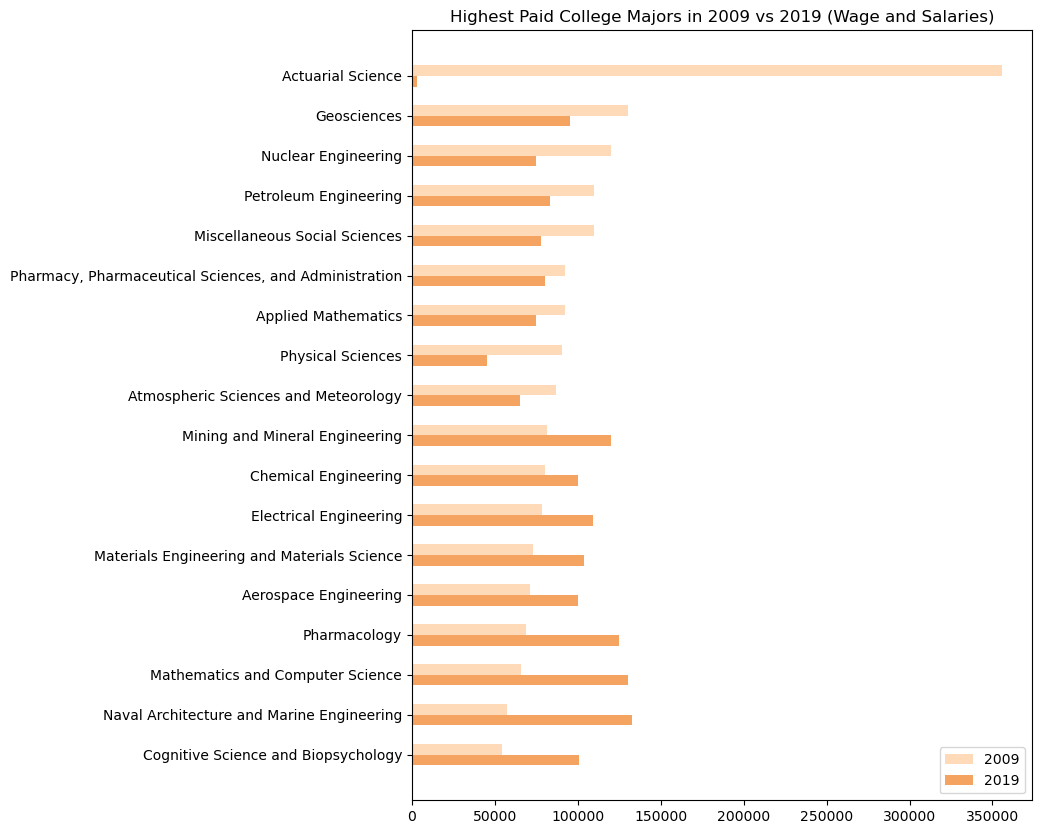

In [143]:
height = 0.8
plt.figure(figsize=(8, 10))

plt.barh(y=np.arange(len(ipums_top_ten_majors))*3+height/2, height=height, 
         width=ipums_top_ten_majors.sort_values("INCWAGE_2009")["INCWAGE_2009"], 
         color="peachpuff", label="2009")

plt.barh(y=np.arange(len(ipums_top_ten_majors))*3-height/2, height=height, 
         width=ipums_top_ten_majors.sort_values("INCWAGE_2009")["INCWAGE_2019"], 
         color="sandybrown", label="2019")

plt.yticks(np.arange(len(ipums_top_ten_majors))*3, ipums_top_ten_majors.sort_values("INCWAGE_2009")["DEGFIELDD"])
plt.title("Highest Paid College Majors in 2009 vs 2019 (Wage and Salaries)")
plt.legend();

<!-- BEGIN QUESTION -->

**Question 3.5:** Comment on the results shown above. Do these results match your expectations? In addition, do you think there is a potential problem related to outliers? If so, what is a good way to mitigate this problem? 

This does match my expetations, esspecially in the cs and engineering realm. Although engineering majors have been popular for decades, the amount of growth in these areas and shrinkage in others, such as actuarial science and natural sciences makes sense. As for outliers, there could be potential for outliers, or change of major name. Maybe actuarial sciences is grouped with business or economics majors at many universities. A good way to mitigate this would be to collect more data on if this is true and then reclassify.

<!-- END QUESTION -->

----
## Section 4: Income Over Life-Cycle (Optional)
In the final section of this lab, we will take a look at how lifetime earnings vary by major. **Although this section is optional, it is by no means more difficult than the previous sections, and we strongly encourage you to try it. The results are also very interesting!** This is related to the [Life-Cycle Hypothesis](https://www.economicshelp.org/blog/27080/concepts/life-cycle-hypothesis/).

For example, some people make a lot of money early in life but don't see a significant increase in income later on; and some other people don't make a lot of money right out of college, but their income increases significantly as they get older. We want to see if this is related to their major, using the most recent data from 2019. 

### Economics Majors

First we will look at the Economics majors. Economics majors contains Agricultural Economics, Economics, and Business Economics, which are represented by `DEGFIELDD` codes 1102, 5501, and 6205. 

**Question 4.1:** Filter the `ipums_s` dataframe for Economics majors based on the criteria above. We only need records for 2019. 

In [147]:
ipums_s_2019_econ = ...
ipums_s_2019_econ

Ellipsis

In [ ]:
grader.check("q4_1")

Now we are going to create a visualization of the life cycle income for Economics majors. We will plot the 25th percentile, 50th percentile, 75th percentile, and 90th percentile incomes on the same graph. The y-axis will be the percentile income, and the x-axis will be age.

We have defined the percentile function for you. It can be used as an aggregation function after the groupby.

In [ ]:
# percentile function used in groupby aggregate
def percentile(n):
    def _percentile(x):
        return np.percentile(x, n)
    _percentile.__name__ = f'percentile_{n}'
    return _percentile

For example, 

```python
>>> df.groupby(...).agg(percentile(25))
```

will return the 25th percentile values in each group. 

<!-- BEGIN QUESTION -->

**Question 4.2:** Plot the 25th, 50th, 75th, 90th percentile wages and salaries for Economics majors at each age. 

Hint: You will need to use groupby on `AGE`. Remember to reset index after groupby and aggregate. 

In [ ]:
percentiles = [25, 50, 75, 90]

plt.figure(figsize=(9, 6))
for p in percentiles:
    ipums_s_2019_econ_p_by_age = ...
    plt.plot(..., label=f"Econ {p}th Percentile")
plt.title("Percentile Wage and Salaries By Age for Economics Majors in 2019")
plt.xlabel("Age")
plt.legend();

<!-- END QUESTION -->

**Note that the graph appears to be very volatile. This is due to our extremely small sample size. However, the overall trend is valid.** 

### Computer Science Majors

This time, repeat the same process for computer science majors. CS majors are represented by `DEGFIELDD` codes 2100, 2101, 2102, 2106, 2107, 2407, and 4005. 

<!-- BEGIN QUESTION -->

**Question 4.3:** Filter the `ipums_s` dataframe for CS majors based on the criteria above. We only need records for 2019. Then plot the 25th, 50th, 75th, 90th percentile wage and salary for CS majors of each age.

In [ ]:
...
plt.title("Percentile Wage and Salaries By Age for CS Majors in 2019")
plt.xlabel("Age")
plt.legend();

<!-- END QUESTION -->

### Comparison

Let's now compare the lifecycle income of Economics majors and CS majors. 

<!-- BEGIN QUESTION -->

**Question 4.4:** Plot the lifecycle wage and salaries of Economics and CS majors together. 

Hint: You only need to copy and paste in the code in the for loop. 

In [ ]:
colors = ['sandybrown', 'coral', 'chocolate', 'sienna', 'cornflowerblue', 'royalblue', 'mediumblue', 'navy']
plt.figure(figsize=(12, 8))

percentiles = [25, 50, 75, 90]
# Economics majors
for i, p in enumerate(percentiles):
    ...
    plt.plot(..., label=f"Econ {p}th Percentile", color=colors[i])

# CS majors
for i, p in enumerate(percentiles):
    ...
    plt.plot(..., label=f"CS {p}th Percentile", color=colors[i+len(percentiles)])
plt.title("Percentile Wage and Salaries By Age in 2019 (Economics vs Computer Science)")
plt.xlabel("Age")
plt.legend();

<!-- END QUESTION -->

**Congratulations!** You're done with Econ 148 Lab 2!

---
## Feedback

**Question 5:** Please fill out this short [feedback form](https://forms.gle/kKzxPm6oUBgxn3Pt8) to let us know your thoughts about this lab! We really appreciate your opinions and feedback! At the end of the Google form, you should see a codeword. Assign the codeword to the variable `codeword` below. 

In [ ]:
codeword = ...

In [ ]:
grader.check("q5")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)